In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
import model_bayesian as model
import emcee
from multiprocess import Pool
from scipy import stats
import scienceplots
plt.style.use('science')

In [2]:
os.environ['OMP_NUM_THREADS'] = '1'

In [3]:
flat_chain = np.load('model_b1.npy')

In [4]:
ns, nd = flat_chain.shape
nskip = ns // 1000

In [5]:
output_dir = 'output_b1/'
model_specifier = 'R_matrix_Bayesian_capture_scatter_'

In [6]:
%%time
ext = model.azr.extrapolate(flat_chain[0], use_gsl=True, ext_capture_file=output_dir + 'intEC.extrap')

CPU times: user 1.14 ms, sys: 4.36 ms, total: 5.5 ms
Wall time: 307 ms


In [7]:
with Pool(4) as pool:
    exts = pool.map(lambda theta: model.azr.extrapolate(theta, use_gsl=True,
                                                        ext_capture_file=output_dir + 'intEC.extrap'),
                    flat_chain[::nskip])

In [8]:
from scipy.optimize import curve_fit

In [9]:
def fit_br0(ext):
    energies, bran_rats = ext[0][:, 0], ext[1][:, 3] / ext[0][:, 3]
    pars, cov = curve_fit(lambda z, m, b: m*z + b, energies, bran_rats)
    return pars


ne = int((0.1 - 0.001) / 0.001)

def fit_S0(extrap):
    x = extrap[-1][:ne, 0]
    y = extrap[-1][:ne, 4]
    pars, cov = curve_fit(lambda z, m, b: m*z + b, x, y)
    return pars

In [10]:
br0_pars = np.array([fit_br0(ext) for ext in exts])

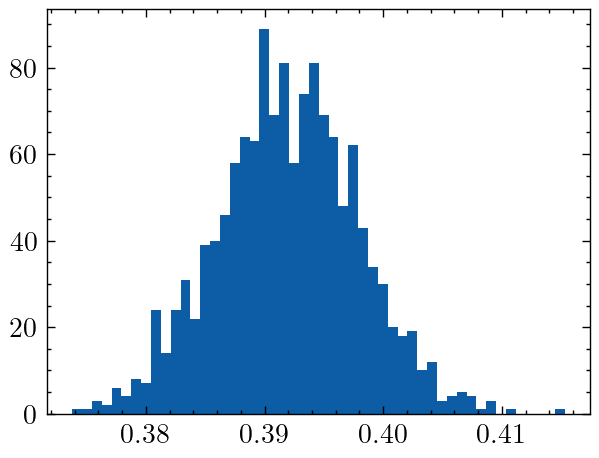

In [11]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.hist(br0_pars[:, 1], bins=50);

In [12]:
np.savetxt(output_dir + model_specifier + 'branching_ratios.txt', br0_pars[:, 1],
           header='Branching Ratio')

In [13]:
low, med, high = np.quantile(br0_pars[:, 1], [0.16, 0.5, 0.84])
print('$%.3f^{+%.3f}_{-%.3f}$' % (med, high-med, med-low))

$0.392^{+0.006}_{-0.006}$


In [14]:
s0_pars = np.array([fit_S0(ext) for ext in exts])

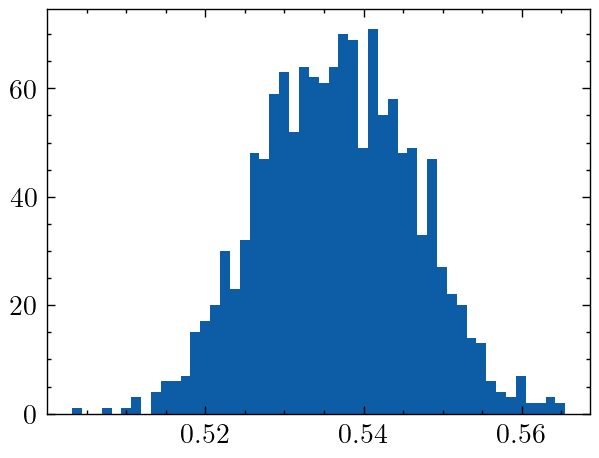

In [15]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.hist(s0_pars[:, 1]*1000, bins=50);

In [16]:
np.savetxt(output_dir + model_specifier + 'S0.txt', s0_pars[:, 1]*1000, header='S(0) in keV b')

In [17]:
low, med, high = np.quantile(s0_pars[:, 1]*1000, [0.16, 0.5, 0.84])
print('%.3f^{+%.3f}_{-%.3f}' % (med, high-med, med-low))

0.537^{+0.010}_{-0.010}


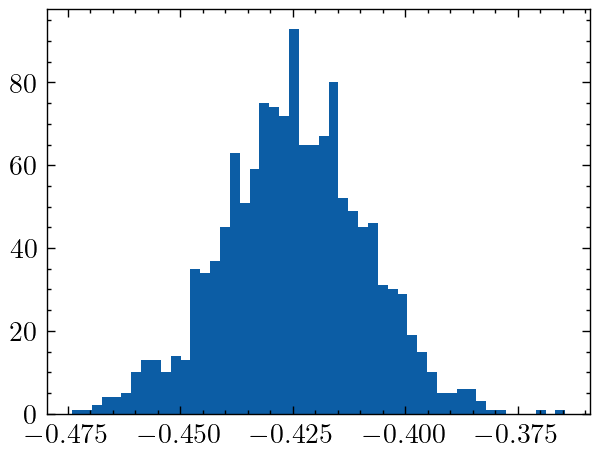

In [18]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.hist(s0_pars[:, 0]/s0_pars[:, 1], bins=50);

In [19]:
np.savetxt(output_dir + model_specifier + 'Sp0S0.txt', s0_pars[:, 0]/s0_pars[:, 1],
           header='S\'(0)/S(0) in inverse MeV')

In [20]:
low, med, high = np.quantile(s0_pars[:, 0]/s0_pars[:, 1], [0.16, 0.5, 0.84])
print('%.2f^{+%.2f}_{-%.2f}' % (med, high-med, med-low))

-0.42^{+0.02}_{-0.02}


In [21]:
def calc_SE(ext):
    return ext[-1][ne:, 4]

In [22]:
ses = np.array([calc_SE(ext) for ext in exts])

In [23]:
np.quantile(ses, [0.025, 0.16, 0.5, 0.84, 0.975], axis=0)

array([[0.00049893, 0.00049665, 0.00049445, ..., 0.00039693, 0.00039774,
        0.00039857],
       [0.00050665, 0.00050443, 0.00050223, ..., 0.0004065 , 0.00040739,
        0.00040829],
       [0.00051551, 0.00051315, 0.00051081, ..., 0.00041674, 0.00041767,
        0.0004186 ],
       [0.00052461, 0.00052225, 0.00051989, ..., 0.00042716, 0.00042813,
        0.00042911],
       [0.00053279, 0.00053029, 0.00052778, ..., 0.00043798, 0.000439  ,
        0.00044003]])

In [24]:
np.savetxt(output_dir + model_specifier + 'SE.txt',
           np.vstack((exts[0][-1][ne:, 0], np.quantile(ses, [0.025, 0.16, 0.5, 0.84, 0.975], axis=0))).T,
           header='S(E)\nE  2.5%  16%  50%  84%  97.5%')